# Exploiting the MCMC

In [1]:
import orsa
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import os

sns.set(style = 'white')
mpl.rc('xtick.minor', visible = True)
mpl.rc('ytick.minor', visible = True)
mpl.rc('xtick', direction='in', top=True, bottom = True)
mpl.rc('ytick', direction='in', right=True, left = True)

print(orsa.__version__)

0.7.1


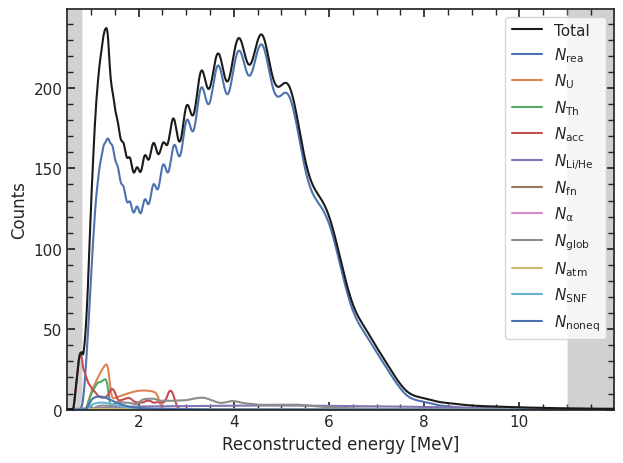

In [2]:
model = orsa.model.read_json('inputs/test_model.json')
model.exposure = 6*365.25
model

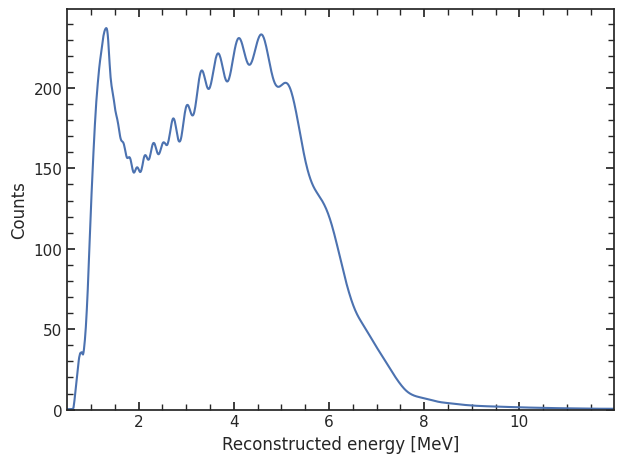

In [3]:
data = model.get_spectrum(asimov = True)
data

In [4]:
for param in model.detector_parameters:
    model.detector_parameters[param].fixed = True

for param in model.core_parameters:
    model.core_parameters[param].fixed = True

for param in model.normalization_parameters:
    if model.normalization_parameters[param].label != 'rea':
        model.normalization_parameters[param].fixed = True

model.parameters['rho'].fixed = True

In [5]:
init_model = model.copy()
min_func_bin = orsa.probability.CostFunction(ll=orsa.probability.chi2, ll_args=dict(data=data), lp_args=model.get_priors())
model.use_shape_uncertainty = False
m_minuit = orsa.fit.minuit(model, min_func_bin)

Cost function parsed as chi2-like


In [6]:
mcmc_path = 'inputs/test_mcmc.h5'
if os.path.isfile(mcmc_path):
    m_mcmc = orsa.fit.parse_emcee(mcmc_path)
    m_mcmc.labels = m_minuit.labels
    m_mcmc.formatted_labels = m_minuit.formatted_labels
    m_mcmc.true_values = m_minuit.true_values
    m_mcmc.data = m_minuit.data
else:
    m_mcmc = orsa.fit.emcee(model, min_func_bin, 10000, err_scale=1e-3, backend=mcmc_path)

Discarded 5000 samples for best fit values. Recalculate them by looking at the chain.


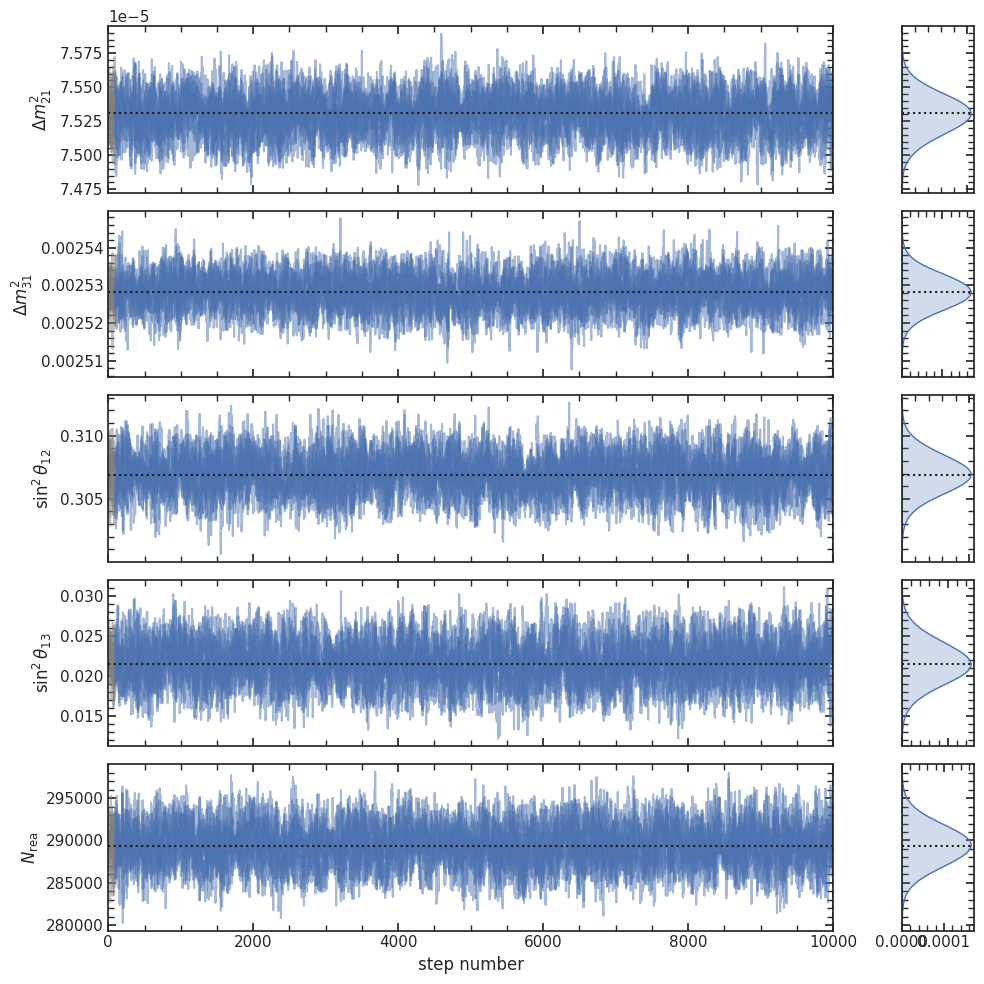

In [7]:
m_mcmc.discard = 100
orsa.plot.chain(m_mcmc);

Removed no burn in


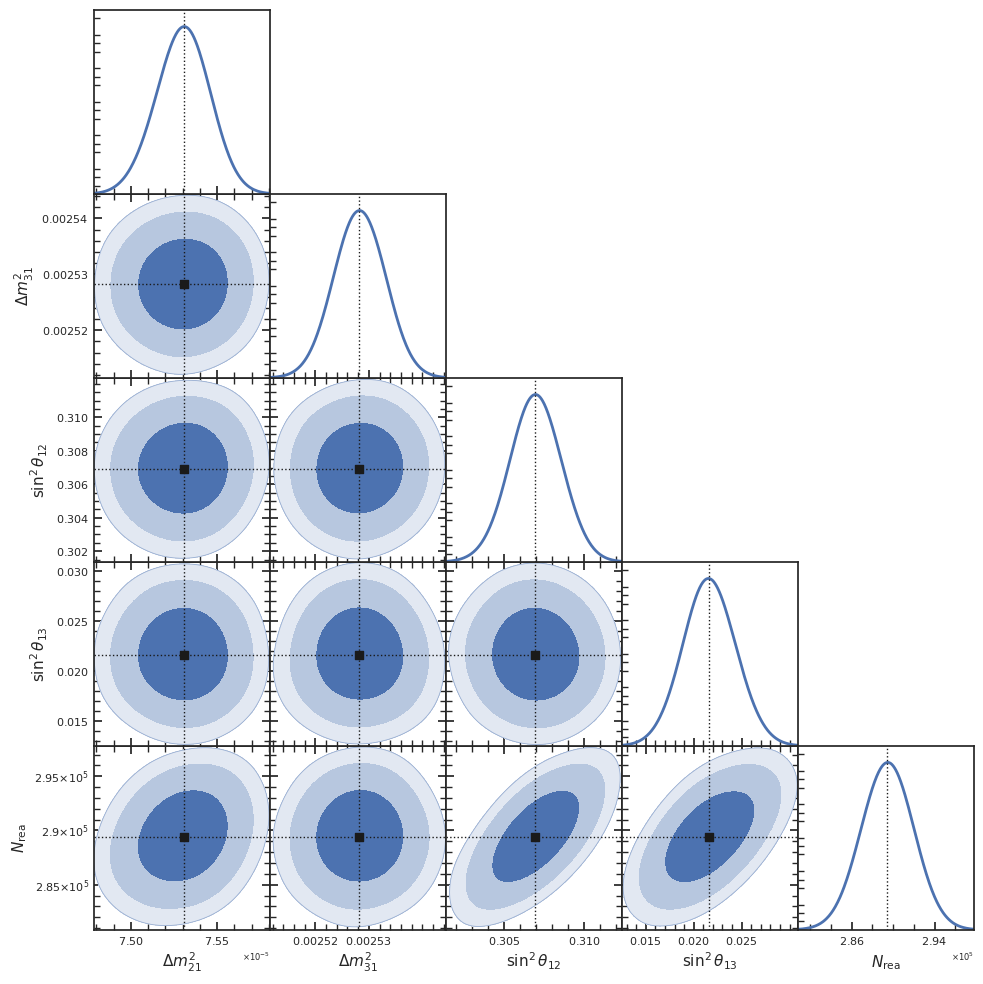

In [8]:
orsa.plot.corner(m_mcmc);

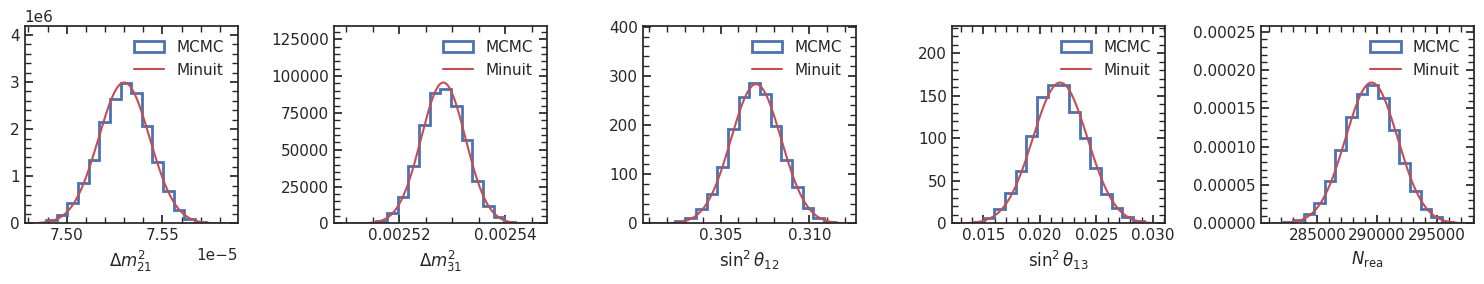

In [9]:
from scipy.stats import norm
n_cols = 5
n_rows = int(np.ceil((len(m_mcmc.values)/n_cols)))
box_size = 3

fig, ax = plt.subplots(n_rows, n_cols, figsize = (n_cols*box_size, n_rows*box_size))
ax = ax.flatten()
for i, l in enumerate(m_mcmc.formatted_labels):
    try:
        n, edges, _ = ax[i].hist(m_mcmc.samples[:,m_mcmc.discard:,i].flatten(), histtype = 'step', bins = 20, density = True, lw = 2, label = 'MCMC')
        x_samples = np.linspace(edges.min(), edges.max(), 1000)
        ax[i].plot(x_samples, norm.pdf(x_samples, m_minuit.values[i], m_minuit.errors[i]), 'r-', label = 'Minuit')
        ax[i].set_xlabel(l)
    except:
        try:
            fig.delaxes(ax[i])
        except:
            pass


    ax[i].margins(x = 0.0, y = 0.4)
    ax[i].legend(frameon = False, loc = 'upper right')
fig.tight_layout()

/home/ubuntu/.miniconda3/lib/python3.10/site-packages/orsa/plot/plot.py:562: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


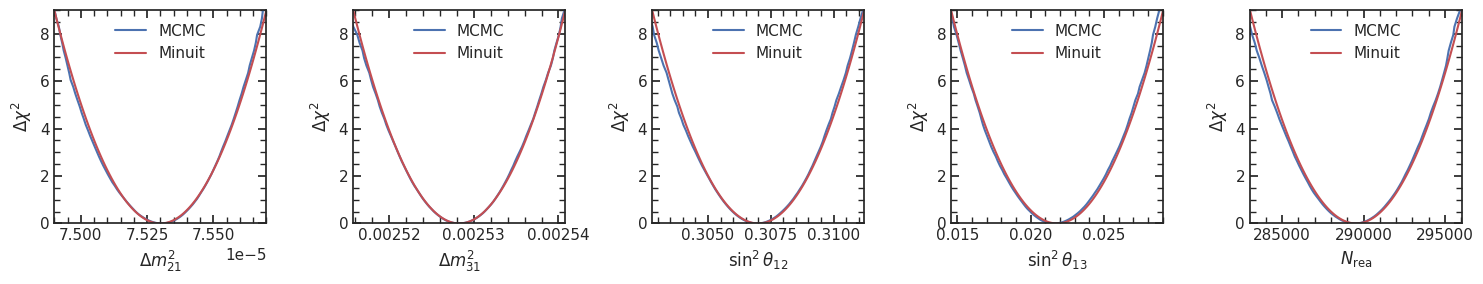

In [10]:
fig, axes = orsa.plot.draw_profiles(m_mcmc, kind='marginal', n_sigmas=3, n_samples=101, plot_kwargs=dict(c = 'b', label = 'MCMC'), subtract_min=True)
fig, axes = orsa.plot.draw_profiles(m_minuit, kind='profile', n_sigmas=3, n_samples=101, plot_kwargs=dict(c = 'r', label = 'Minuit'), subtract_min=True, axes = axes)
for ax in axes:
    try: ax.legend(frameon = False)
    except: pass